In [2]:
# ================================
# Import Libraries
# ================================

# Libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn utilities for splitting data and evaluation metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# Gaussian Process Regressor and kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, ConstantKernel, Matern, RationalQuadratic, WhiteKernel
)

# For data scaling
from sklearn.preprocessing import StandardScaler

# For custom LBFGS with more iterations
from scipy.optimize import minimize

# Set seed for reproducibility
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

In [3]:
# ================================
# Load and Inspect Dataset
# ================================

# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("\nDataset loaded successfully...")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()
    
# Overwrite df with a random 'little' subset of the data
df = df.sample(frac=0.005, random_state=RANDOM_STATE)

# Display dataset information
print("\nDataset Information:")
df.info()

print("\nFirst Five Rows of the Dataset:")
display(df.head())


Dataset loaded successfully...

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3282 entries, 313592 to 281728
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         3282 non-null   object 
 1   device_id    3282 non-null   object 
 2   co2          3282 non-null   float64
 3   humidity     3282 non-null   float64
 4   pm25         3282 non-null   float64
 5   pressure     3282 non-null   float64
 6   temperature  3282 non-null   float64
 7   rssi         3282 non-null   float64
 8   snr          3282 non-null   float64
 9   SF           3282 non-null   int64  
 10  frequency    3282 non-null   float64
 11  f_count      3282 non-null   float64
 12  p_count      3282 non-null   float64
 13  toa          3282 non-null   float64
 14  distance     3282 non-null   int64  
 15  c_walls      3282 non-null   int64  
 16  w_walls      3282 non-null   int64  
 17  exp_pl       3282 non-null   float

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
313592,2025-01-11 13:35:19.856635+00:00,ED2,555.0,32.97,1.55,329.89,21.58,-66.0,11.5,8,868.3,102665.0,113691.0,0.133632,23,0,2,83.4,-77.797062,-66.297062
630637,2024-12-30 21:46:56.370059+00:00,ED5,470.0,40.38,1.92,332.88,15.92,-103.0,4.0,10,868.5,88556.0,96940.0,0.452608,40,2,2,120.4,-108.455405,-104.455405
270588,2024-11-25 21:53:52.441632+00:00,ED2,636.0,36.04,0.47,317.03,24.17,-76.0,7.2,7,868.5,41805.0,46588.0,0.071936,23,0,2,93.4,-83.957462,-76.757462
413399,2025-01-01 18:34:20.159798+00:00,ED3,423.0,32.93,1.55,314.81,19.84,-67.0,9.8,7,867.1,89126.0,99595.0,0.071936,18,1,2,84.4,-77.232494,-67.432494
67181,2024-12-11 14:12:50.857692+00:00,ED0,781.0,35.08,1.30,332.34,21.95,-48.0,12.5,9,868.1,61949.0,69135.0,0.246784,10,0,0,65.4,-60.737602,-48.237602


In [4]:
# ================================
# Define Features and Target
# ================================

# Feature columns:
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Ensure all columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features (X) and target (y)
X = df[feature_columns].values
y = df[target_column].values

# ================================
# Scale the data
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80-20)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
)

print("\nTrain-test split completed...\n")


Train-test split completed...



In [5]:
# ================================
# Train Gaussian Process Regressor
# ================================

# Custom LBFGS optimizer with maxiter
def custom_optimizer(obj_func, initial_theta, bounds):
    """
    L-BFGS = Limited-memory Broyden–Fletcher–Goldfarb–Shanno
    This is a variant of the BFGS quasi-Newton method that uses less memory 
    (thus “limited-memory”) and is well-suited for high-dimensional problems where 
    storing the full Hessian is impractical.
    
    B = Bound-constrained
    This means the algorithm supports specifying upper and lower bounds on the parameters 
    it is optimizing.
    So, L-BFGS-B is a bounded, limited-memory quasi-Newton method that is commonly used to 
    solve optimization problems in machine learning libraries (like scikit-learn), 
    including hyperparameter optimization for Gaussian Processes.
    
    Custom optimizer using L-BFGS-B with a higher iteration budget.
    Expects obj_func(theta) -> (f, grad).
    """
    def func_and_grad(theta):
        # obj_func returns (function_value, gradient)
        f, g = obj_func(theta)
        return f, g

    # Tell minimize that 'func_and_grad' also returns gradients via jac=True
    opt_res = minimize(
        fun=func_and_grad,
        x0=initial_theta,
        method='L-BFGS-B',
        jac=True,            # <--- Important: we have an analytic gradient
        bounds=bounds,
        options={'maxiter': 2000}  # To be increased if case of convergence warnings
    )
    return opt_res.x, opt_res.fun


# Define a kernel (can be tuned further)
# kernel: RBF + WhiteKernel to account for noise

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) \
         * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-9, 1))  

# Initialize the Gaussian Process Regressor
# alpha is the value added to the diagonal of the kernel matrix during fitting
# n_restarts_optimizer tries multiple starting points to find a better fit
# optimizer is our custom LBFGS with more iterations
gpr_model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    n_restarts_optimizer=10,
    random_state=RANDOM_STATE,
    optimizer=custom_optimizer  # <-- using our custom LBFGS
)

print("\nTraining Gaussian Process Regressor with the chosen kernel...\n")

gpr_model.fit(X_train_all, y_train_all)

print("Model training completed...\n")


Training Gaussian Process Regressor with the chosen kernel...



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model training completed...



In [6]:
# ================================
# Evaluate Model Performance
# ================================

print("\nEvaluating the trained GPR model...")

# Predictions on the training set
y_train_pred = gpr_model.predict(X_train_all)
# Predictions on the test set
y_test_pred = gpr_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(y_train_all, y_train_pred)
test_mse = mean_squared_error(y_test_all, y_test_pred)
train_r2 = r2_score(y_train_all, y_train_pred)
test_r2 = r2_score(y_test_all, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test_all, y_test_pred)
test_median_ae = median_absolute_error(y_test_all, y_test_pred)

# Store metrics in a DataFrame for display
evaluation_metrics = [
    {
        'Model': 'GaussianProcessRegressor',
        'Training MSE': train_mse,
        'Test MSE': test_mse,
        'Test RMSE': test_rmse,
        'R² Score': test_r2,
        'Test MAPE (%)': test_mape * 100,
        'Test Median AE': test_median_ae
    }
]

evaluation_df = pd.DataFrame(evaluation_metrics)

print("\nModel Evaluation Metrics:")
display(evaluation_df.T[1:].reset_index(names=["Metric"]).rename(columns={0: "Value"}))


Evaluating the trained GPR model...

Model Evaluation Metrics:


,Metric,Value
0,Training MSE,0.372288
1,Test MSE,129.364476
2,Test RMSE,11.373851
3,R² Score,0.61148
4,Test MAPE (%),7.325569
5,Test Median AE,3.754702


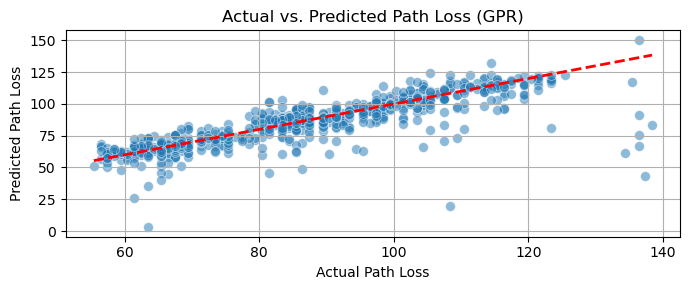

In [7]:
# ================================
#  Plot Actual vs Predicted
# ================================

plt.figure(figsize=(7, 3))
sns.scatterplot(x=y_test_all, y=y_test_pred, alpha=0.5, edgecolor='w', s=50)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs. Predicted Path Loss (GPR)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# ================================
# Manual K-Fold Cross-Validation
# ================================

# Number of folds
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
print("\nPerforming K-Fold Cross-Validation for GPR...\n")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_all), start=1):
    
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    y_train_fold, y_val_fold = y_train_all[train_idx], y_train_all[val_idx]
    
    # Re-initialize the GPR model for each fold
    gpr_fold_model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-9,
        n_restarts_optimizer=10,
        random_state=RANDOM_STATE
    )
    
    # Train on fold
    gpr_fold_model.fit(X_train_fold, y_train_fold)
    
    # Predict on validation set
    y_val_pred = gpr_fold_model.predict(X_val_fold)
    
    # Compute metrics
    val_mse = mean_squared_error(y_val_fold, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val_fold, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    val_median_ae = median_absolute_error(y_val_fold, y_val_pred)
    
    cv_results.append({
        'Fold': fold,
        'Validation MSE': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })
    
    print(f" Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, "
          f"MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")

# Convert the cross-validation results into a DataFrame
cv_results_df = pd.DataFrame(cv_results)

print("K-Fold Cross-Validation Results:")
display(cv_results_df)

# Calculate summary statistics (mean, std) for the folds
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

print("\nCross-Validation Summary:")
display(cv_summary.set_index('Metric').T)


Performing K-Fold Cross-Validation for GPR...



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 Fold 1 - MSE: 164.9712, RMSE: 12.8441, R²: 0.5621, MAPE: 7.55%, Median AE: 4.2006



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 Fold 2 - MSE: 111.1142, RMSE: 10.5411, R²: 0.6993, MAPE: 7.54%, Median AE: 4.4221



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 Fold 3 - MSE: 108.2078, RMSE: 10.4023, R²: 0.6673, MAPE: 7.42%, Median AE: 4.2624



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 Fold 4 - MSE: 142.2277, RMSE: 11.9259, R²: 0.5917, MAPE: 7.47%, Median AE: 4.3345



C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\envs\ml_models_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 Fold 5 - MSE: 132.8459, RMSE: 11.5259, R²: 0.6299, MAPE: 7.73%, Median AE: 4.0984

K-Fold Cross-Validation Results:


,Fold,Validation MSE,Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,164.9712,12.8441,0.5621,7.55,4.2006
1,2,111.1142,10.5411,0.6993,7.54,4.4221
2,3,108.2078,10.4023,0.6673,7.42,4.2624
3,4,142.2277,11.9259,0.5917,7.47,4.3345
4,5,132.8459,11.5259,0.6299,7.73,4.0984



Cross-Validation Summary:


Metric,mean,std
Fold,3.0000,1.5811
Validation MSE,131.8734,23.4234
Validation RMSE,11.4479,1.0124
R² Score,0.6301,0.0554
Validation MAPE (%),7.5420,0.1178
Validation Median AE,4.2636,0.1239
